# Introduction

This notebook provides an overview of the available data to explore, the data collection process and the approach to preprocessing the kinematic data for the downloaded dance video dataset.

## Data Collection using Youtube Data API and Pytube

The video data used for exploratory data analysis was downloaded using the [Youtube Data API](https://developers.google.com/youtube/v3/docs/search/list) and [Pytube](https://pytube.io/en/latest/), which ensured that only authorized videos were collected for analysis. To increase the likelihood of finding relevant and clean videos that focused on individual dancers rather than groups, the code function used a keyword search that included the genre name and terms such as "solo choreography", "solo practice", or "dance cover". The expected video format is `mp4`, `width:360`, `height:640`, `max_length:120`, `min_views:100`.

For more details about the data collection process, please refer to the code in [/src/data/collection.py](https://github.com/kayesokua/gestures/blob/main/src/data/collection.py)

In [ ]:
from src.data.collection import extract_video_from_youtube

extract_video_from_youtube(query='contemporary', max_count=5)
extract_video_from_youtube(query='ballet', max_count=5)
extract_video_from_youtube(query='folk', max_count=5)

## Pose Estimation using MediaPipe

After downloading the video data, the kinematic data will be extracted using [MediaPipe Pose Solution](https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md). The chosen output format is `csv` with relative values by default. In this file, we obtain `x`,`y`,`z` coordinates and obtain the `fps` using [OpenCV](https://docs.opencv.org/4.x/). We use `NaN` to frames where a pose cannot be detected. 

The code snippet below gathers all videos in `mp4` format and extracts landmarks and screenshots. For more details about the data annotation process, please refer to the code in [/src/data/annotation.py](https://github.com/kayesokua/gestures/blob/main/src/data/annotation.py)

In [ ]:
import os
from src.data.annotation import extract_landmarks_from_videos

video_path = 'data/external'

if os.path.exists(video_path):
    extract_landmarks_from_videos(video_path)
else:
    print("Path does not exists.")

## Extracting Audio Features using Librosa

[Librosa](https://librosa.org/doc/latest/index.html) lets you extract audio features and add more context to the dance gestures analysis.

* **Tempo** and **Beat Times** are important audio features that can be used to identify the rhythmic structure and timing of the music in a dance video. 
* **Full Signal** tells us about the sound of the performance, including tempo, rhythm, and melody. This helps us understand how the music and dance movements are synchronized.
* **Percussive signal** shows us the timing of the dance movements and how they relate to the beat of the music, helping us identify accents. (Behavioral Gestures)
* **Harmonic Signal** tells us about the emotional and expressive elements of the performance. (Expressive Gestures)

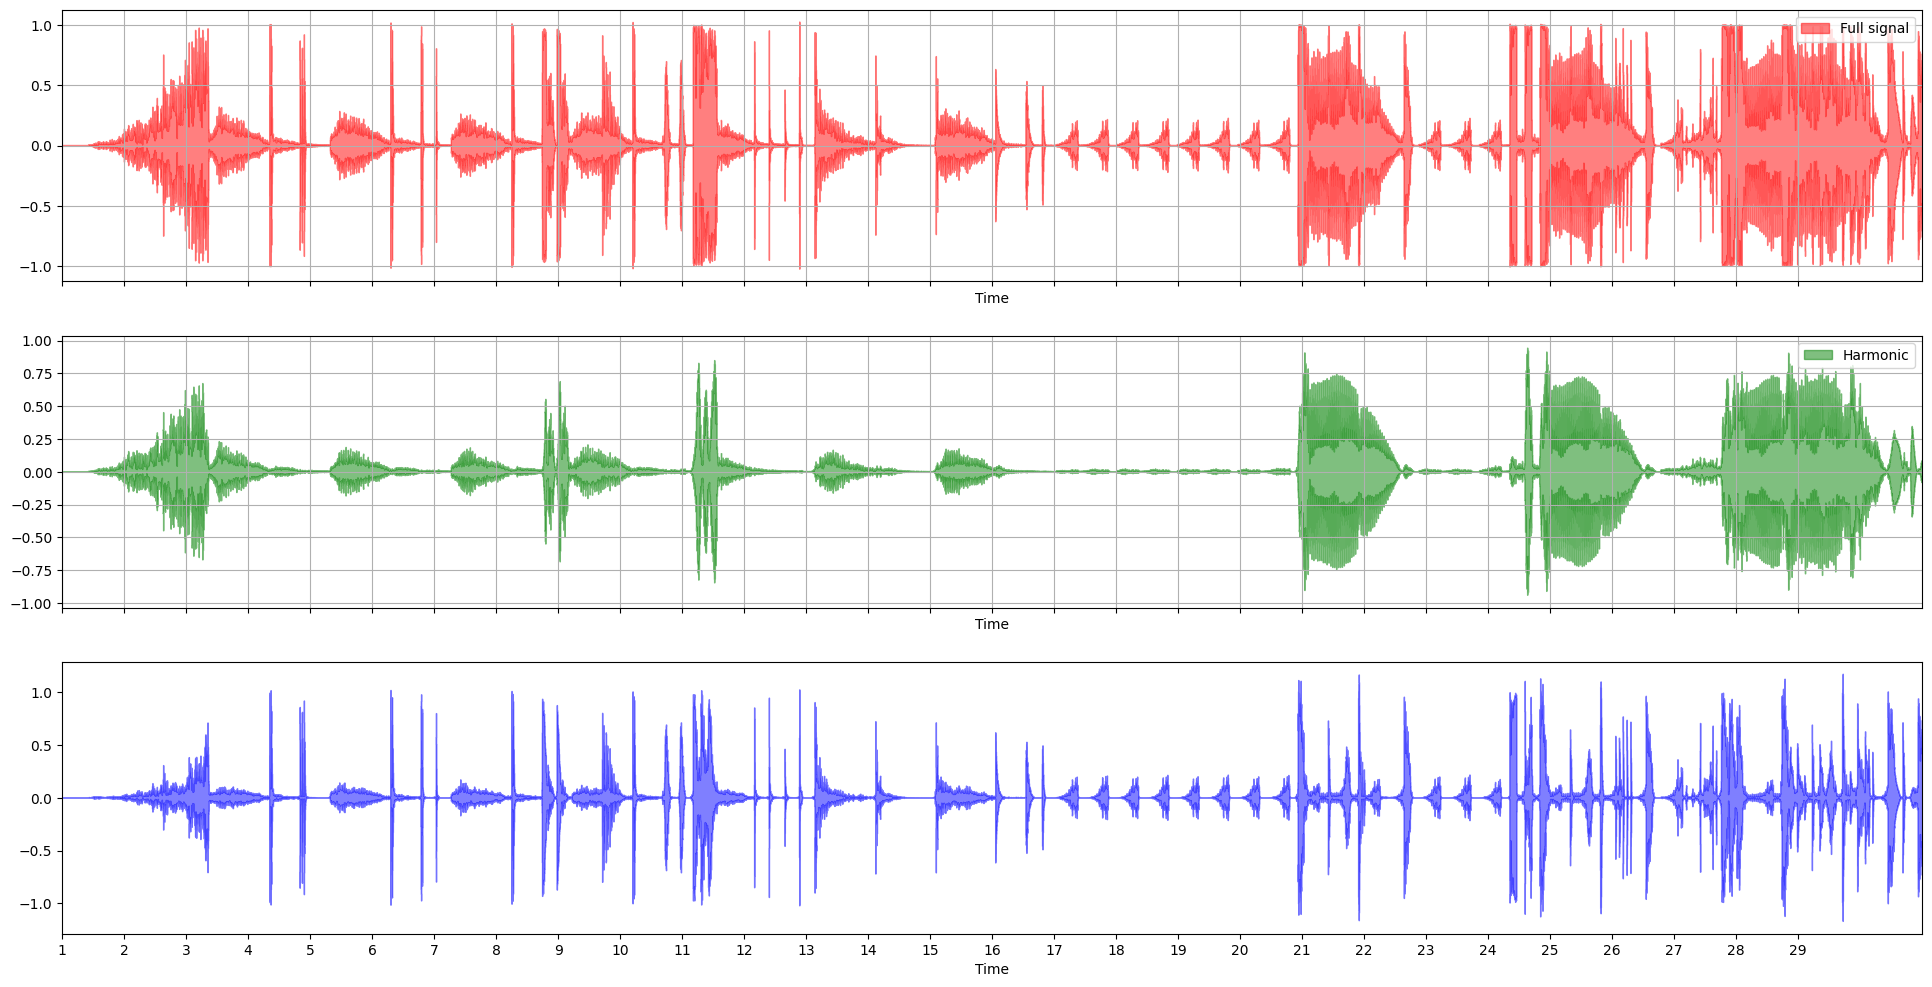

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.gridspec import GridSpec
import librosa
import librosa.display
from src.features.audio import extract_tempo_and_beats

video_url_path = "./data/external/contemporary_001.mp4"
tempo, beat_times = extract_tempo_and_beats(video_url_path)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(24, 12))
y, sr = librosa.load(video_url_path)
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y, sr=sr, color='r', alpha=0.5, ax=ax[0], marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, color='g', alpha=0.5, ax=ax[1], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='b', alpha=0.5, ax=ax[2], label='Percussive')
for i in range(2):
    ax[i].set_xlim(2,31)
    ax[i].legend()
    ax[i].set_xticks(np.arange(1, 30, 1))
    ax[i].grid()
plt.show()

## Handling Missing Poses and Outlier Detection

Since we are handling dance videos with different cinematography style, using linear interpolation or median might not be appropriate for handling missing kinematic data. Therefore, the proposed solution is to detect outliers instead by generating binary label using [Isolation Forest algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).  `1` indicates normal data and `-1` indicates the outlier.

For more details about the data processing, please refer to the code in [/src/data/processing.py](https://github.com/kayesokua/gestures/blob/main/src/data/processing.py)

In [ ]:
from src.data.processing import process_landmarks_using_isolation_forest
process_landmarks_using_isolation_forest("data/interim")

## Data Cleaning

Currently, only minimal data cleaning is required, which involves verifying whether all videos are of the same size.

In [ ]:
from src.data.processing import check_video_size

if check_video_size('data/external'):
    print("All videos have the same size.")
else:
    print("Videos have different sizes.")

## Summary

This notebook provided an overview of the data we have for exploration

1. Videos (MP4) with category as filename: `data/external/{category_i}.mp4`
2. Kinematic data with outliers information(CSV): `data/processed/{category_i}.csv`
3. Frame screenshots (PNG) saved in chronological order: `data/interim/{video_filename}/*.png`
4. Audo features: `tempo`,`beat_times`, `full signals`,`harmonic`,`harmonic`, `percussive`


## Resources

For a comprehensive list of resources, [please see here](https://github.com/kayesokua/gestures/blob/main/references/README.md).